In [1]:
# Import packages
from vcodatools.db.conn import StarburstConnection

import trino


from sqlalchemy import text

import re

import os

import openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

# Show all the columns when displaying a dataframe
pd.set_option("display.max_columns", None)

In [2]:
# Seaborn/matplotlib plot settings
sns.set_theme(
    context="notebook",
    style="darkgrid",
    palette="pastel",
)

In [3]:
df = pd.read_excel(r"C:\Users\aiyer\Desktop\labor-cost-forecast\data\raw\sie_fi.xlsx")
df.set_index("expenditure_item_date", inplace=True)
df["task_number"] = df["task_number"].astype(str)
df["project_number"] = df["project_number"].astype(str)

In [4]:
imp_tasks_df = df[df["task_number"].str[0:4].isin(IMPORTANT_TASKS)]
imp_tasks_df[imp_tasks_df["regular_time"] == 0]

# Drop rows with 0 regular time or 0 regular cost
df = df[(df["regular_time"] != 0) & (df["raw_cost"] != 0)]

In [5]:
df["task_name"].value_counts()

task_name
Installation            8557
Task 0                  4940
General                 2463
Labor                   2387
Systems Engineering     2226
                        ... 
Product BOM Developm       1
Software Engineering       1
Texas Install              1
Outdoor rack layout/       1
System Cabling and d       1
Name: count, Length: 1804, dtype: int64

In [6]:
with pd.option_context("display.max_rows", None):
    print(df[df["project_name"] == "Swordfish Antennas"]["task_name"].value_counts())

task_name
System Cabling/Racks    318
Installation            229
Install, Integration    221
Design Clean Up         172
Inatllaiton Ant #3      152
HW Design Eng           147
Build Integrate Test    143
Matl & Ops Mgmt         107
Post FAT Design          93
Engineering LOE          91
Stage & Factory/FAT      78
PAT, Plan & Test Fix     71
Eng Teardown Sppt        56
Install Planning         49
RF Isolation Ant# 1      36
Servo Run Box            32
Install Tech Sppt        28
Camera Int-CLOSED        26
Technical Support BH     24
Corrective Maintenan     20
Antenna Testing          18
RF Power Baselining      17
Training-CLOSED          16
OPS Support Labor        15
Communications Dev       14
Systems Engineering      12
RF Loopback Upgrade       9
Design Rwk-Supp Chgs      9
Positioner/Riser Dev      9
Manual Updates            9
RF Iso. & PM Design       8
Large Antenna Build       8
3456 Manual               7
RTX Post-FAT Test         7
Ops Mgt & Planning        6
Reflector/

In [7]:
df["incurred_org"].value_counts()

incurred_org
Eng - AS                                     71824
Ops - AS Manufacturing                        5906
Eng - AS Maint & Support                      3919
Eng - GSN System Int & Test Government        1365
AS Antenna Products                            999
Sat Prod Ops Atl - Logistics                   703
VSAT Ntwks - Training                          391
AS R & D                                       352
Eng - AS Ground Sys and Admin                  206
VSAT Ntwks - Hardware Engineering               96
CS - Residential Field Ops - Installation       89
Name: count, dtype: int64

In [8]:
df["project_name"].value_counts()

project_name
Thunderbolt                       6788
WIP                               3347
Swordfish Antennas                2306
Labor                             2236
Spitfire 13M Qty 11               1553
                                  ... 
Cable & Wireless 200300265           1
Relentless T&M                       1
Tanjore 200300379R                   1
H92222-18-D-0005 H9240121F0046       1
Tranche2                             1
Name: count, Length: 973, dtype: int64

In [9]:
# Replace all the 'N' and 'Y' with 0 and 1


df = df.replace({"N": 0, "Y": 1})


# Add month feature


df["month"] = df.index.month


# Add day of week feature


df["day_of_week"] = df.index.dayofweek


# Add day of month feature


df["day_of_month"] = df.index.day


# Add year feature


df["year"] = df.index.year


# Add quarter feature


df["quarter"] = df.index.quarter


# Drop NA columns


df.dropna(axis=1, how="all", inplace=True)


# Drop 0 columns & columns with all the same value


df = df.loc[:, df.nunique() > 1]


try:
    df = df.drop("item_description", axis=1)


except:
    pass

In [10]:
# Define the order of the projects
project_order = ["Riptide", "Thunderbolt", "Swordfish Antennas", "Sailfish"]

# Define a dataframe with the projects in the order specified
df_projects = df[df["project_name"].isin(project_order)]

sie_fi_tasks_df = df_projects[
    df_projects["task_number"].isin(["3110", "3180", "3220", "4200"])
]

Riptide total labor time: 6443.15 hours
Thunderbolt total labor time: 0.0 hours
Swordfish Antennas total labor time: 7094.799999999999 hours
Sailfish total labor time: 288.5 hours


Text(0.5, 1.0, 'Cumulative Labor Time Over Time by Project')

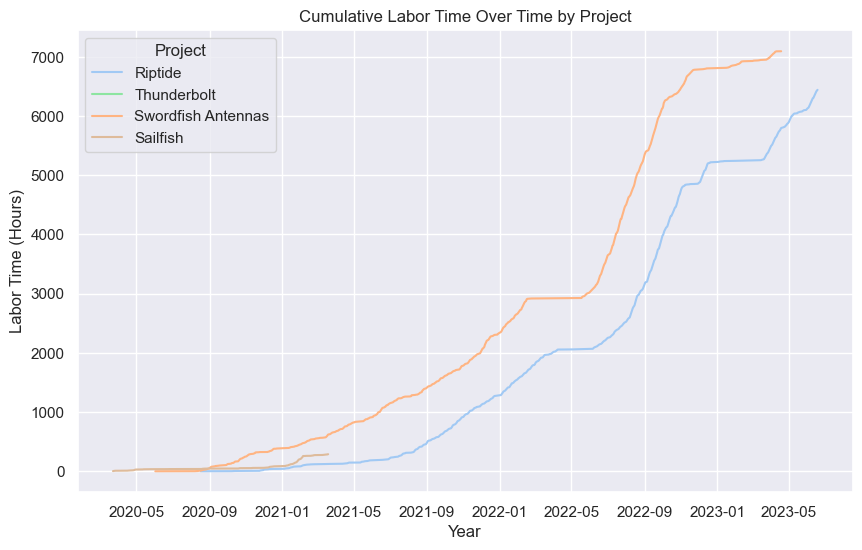

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))


# Plot cumulative labor time over time for each project

for project in project_order:
    color = project_colors[project]
    project_df = sie_fi_tasks_df[sie_fi_tasks_df["project_name"] == project]
    cumul_labor_time = get_grouped_cumsum(
        project_df, "regular_time", "expenditure_item_date"
    )

    ax.plot(cumul_labor_time.index, cumul_labor_time.values, label=project, color=color)

    last_time = project_df["regular_time"].sum()
    print(f"{project} total labor time: {last_time} hours")


ax.legend(title="Project")


ax.set_xlabel("Year")


ax.set_ylabel("Labor Time (Hours)")


ax.set_title("Cumulative Labor Time Over Time by Project")

Riptide total raw cost: 240142.2799999999
Thunderbolt total raw cost: 0.0
Swordfish Antennas total raw cost: 262768.11999999994
Sailfish total raw cost: 11481.769999999995


C:\Users\aiyer\AppData\Local\Temp\ipykernel_21904\1611966065.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"${x/1000000}" for x in ax.get_yticks()])


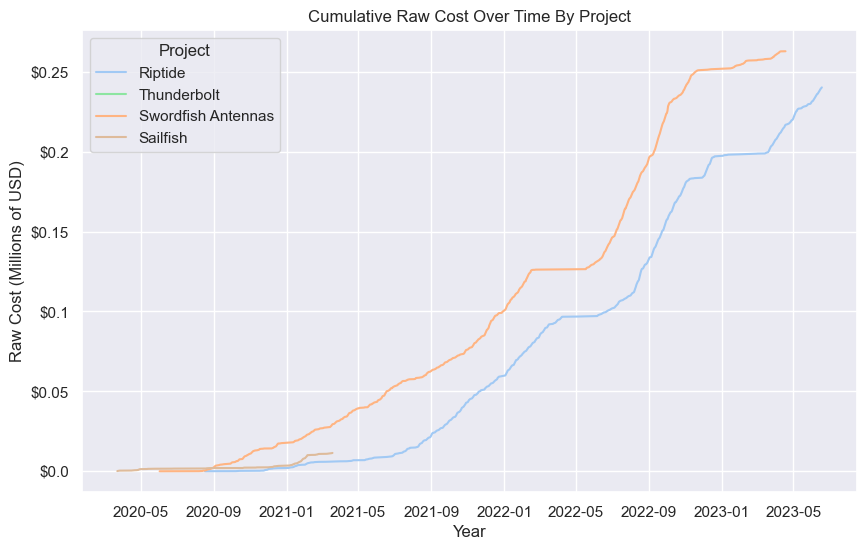

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot cumulative labor time over time for each project
for project in project_order:
    color = project_colors[project]
    project_df = sie_fi_tasks_df[sie_fi_tasks_df["project_name"] == project]
    cumul_labor_time = get_grouped_cumsum(
        project_df, "raw_cost", "expenditure_item_date"
    )
    ax.plot(cumul_labor_time.index, cumul_labor_time.values, label=project, color=color)

    last_cost = project_df["raw_cost"].sum()
    print(f"{project} total raw cost: {last_cost}")


ax.set_ylabel("Raw Cost (Millions of USD)")
ax.set_xlabel("Year")
ax.legend(title="Project")
ax.set_title("Cumulative Raw Cost Over Time By Project")

import matplotlib.ticker as ticker

formatter = ticker.ScalarFormatter(useOffset=True, useMathText=True)
formatter.set_scientific(False)

# Apply the formatter to the y-axis of your plot
ax.set_yticklabels([f"${x/1000000}" for x in ax.get_yticks()])

# Redraw the plot with the updated formatter
plt.draw()

<Axes: title={'center': 'Total Time by Program'}, xlabel='Total Time', ylabel='Labor Time (Hours)'>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


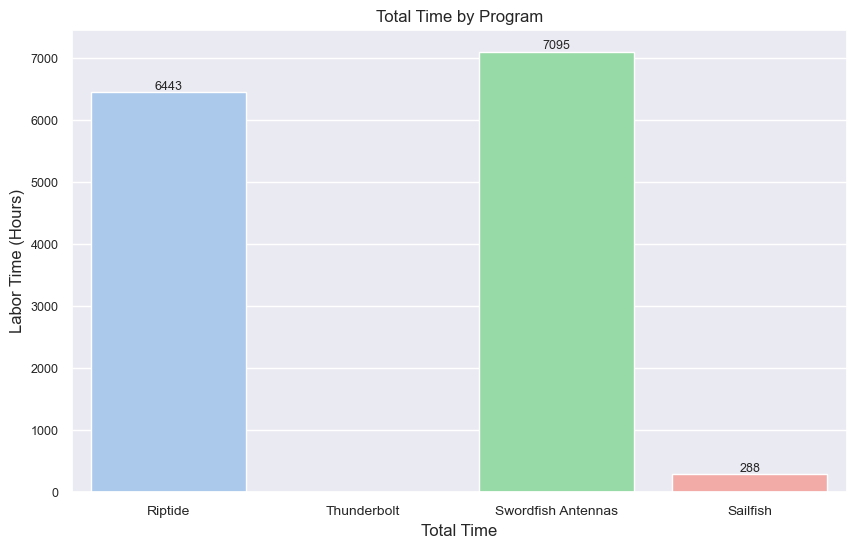

In [13]:
# Total time by program plot
fig, ax = plt.subplots(figsize=(10, 6))

total_time_by_program = sie_fi_tasks_df.groupby("project_name")["regular_time"].sum()

plot_value_counts_density(
    total_time_by_program,
    title="Total Time by Program",
    xlabel="Total Time",
    ylabel="Labor Time (Hours)",
    xticklabel_rotation=0,
    xticklabel_fontsize=10,
    barlabel_fontsize=9,
    order=project_order,
)

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore

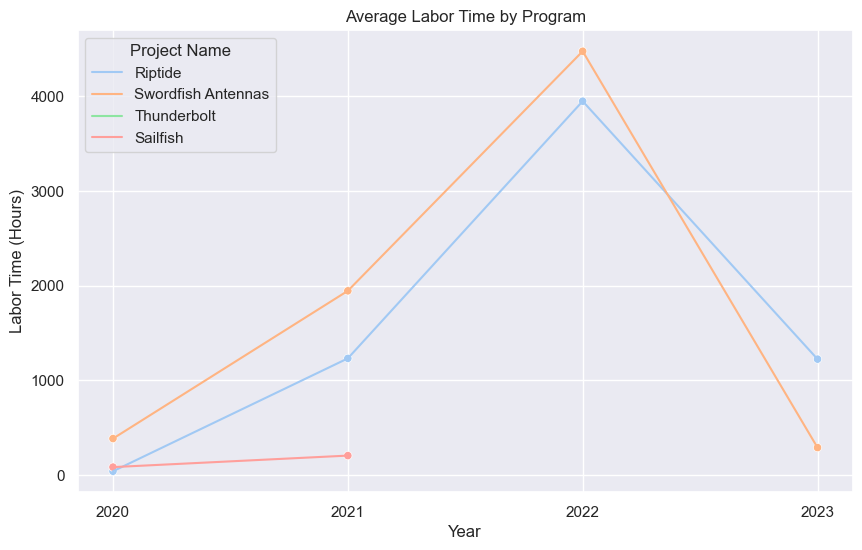

In [14]:
def plot_yearly_stat_by_program(df, stat, hue_order=None):
    # Avg yearly time by program

    fig, ax = plt.subplots(figsize=(10, 6))

    avg_yearly_stat_by_program = df.groupby(["project_name", "year"])[
        "regular_time"
    ].sum()

    # Plot avg yearly time by program with year as the x-axis, and each project as a side-by-side bar, and the regular_time being the y axis without plot_value_counts_density (lineplot)

    avg_yearly_stat_by_program = avg_yearly_stat_by_program.reset_index()

    sns.lineplot(
        x="year",
        y=stat,
        hue="project_name",
        data=avg_yearly_stat_by_program,
        hue_order=hue_order,
    )

    sns.scatterplot(
        x="year",
        y=stat,
        hue="project_name",
        data=avg_yearly_stat_by_program,
        legend=False,
        hue_order=hue_order,
    )

    # only choose the first three lines of the legend

    plt.legend(
        title="Project Name",
        loc="upper left",
    )

    plt.xlabel("Year")
    if stat == "regular_time":

        plt.ylabel("Labor Time (Hours)")
        plt.title("Average Labor Time by Program")
    elif stat == "raw_cost":
        plt.ylabel("Raw Cost (USD)")
        plt.title("Average Labor Cost by Program")

    # Make x tick labels integers

    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))


plot_yearly_stat_by_program(
    sie_fi_tasks_df,
    "regular_time",
    hue_order=["Riptide", "Swordfish Antennas", "Thunderbolt", "Sailfish"],
)

In [15]:
# import plotly.graph_objs as go
# from plotly.subplots import make_subplots

# # Create a figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# # Calculate avg yearly time by program
# avg_yearly_time_by_program = (
#     sie_fi_tasks_df.groupby(["project_name", "year"])["regular_time"]
#     .sum()
#     .reset_index()
# )

# # Add traces for avg yearly time by program
# for project in avg_yearly_time_by_program["project_name"].unique():
#     project_data = avg_yearly_time_by_program[
#         avg_yearly_time_by_program["project_name"] == project
#     ]
#     fig.add_trace(
#         go.Scatter(
#             x=project_data["year"],
#             y=project_data["regular_time"],
#             mode="lines+markers",
#             name=f"{project} Time",
#             line=dict(dash="solid"),  # Solid line for time
#         ),
#         secondary_y=False,
#     )

# # Calculate avg yearly raw_cost by program
# avg_yearly_raw_cost_by_program = (
#     sie_fi_tasks_df.groupby(["project_name", "year"])["raw_cost"].sum().reset_index()
# )

# # Add traces for avg yearly raw_cost by program
# for project in avg_yearly_raw_cost_by_program["project_name"].unique():
#     project_data = avg_yearly_raw_cost_by_program[
#         avg_yearly_raw_cost_by_program["project_name"] == project
#     ]
#     fig.add_trace(
#         go.Scatter(
#             x=project_data["year"],
#             y=project_data["raw_cost"],
#             mode="lines+markers",
#             name=f"{project} Cost",
#             line=dict(dash="dot"),  # Dotted line for cost
#         ),
#         secondary_y=True,
#     )

# # Add titles and labels
# fig.update_layout(
#     title_text="Average Yearly Time and Cost by Program",
#     xaxis_title="Year",
# )

# # Set y-axes titles
# fig.update_yaxes(title_text="Labor Time (Hours)", secondary_y=False)
# fig.update_yaxes(title_text="Raw Cost (USD)", secondary_y=True)

# # Show the figure
# fig.show()

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore

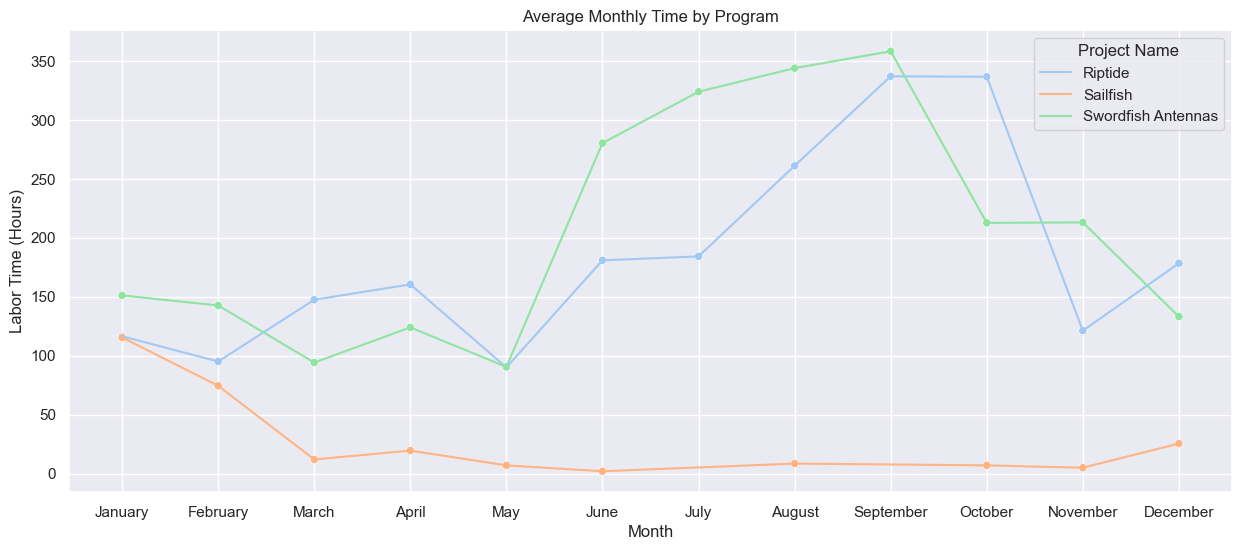

In [16]:
def plot_monthly_stat_by_program(df, stat, hue_order=None):
    # Avg Monthly time by program

    fig, ax = plt.subplots(figsize=(15, 6))

    avg_monthly_stat_by_year_and_program = df.groupby(
        ["project_name", "year", "month"]
    )[stat].sum()

    avg_monthly_stat_by_program = avg_monthly_stat_by_year_and_program.groupby(
        ["project_name", "month"]
    ).mean()

    avg_monthly_stat_by_program = avg_monthly_stat_by_program.reset_index()

    sns.lineplot(
        x="month",
        y=stat,
        data=avg_monthly_stat_by_program,
        hue="project_name",
    )

    sns.scatterplot(
        x="month",
        y=stat,
        data=avg_monthly_stat_by_program,
        hue="project_name",
        legend=False,
    )

    # Make xticks the month names and every month

    plt.xticks(
        ticks=range(1, 13),
        labels=[
            "January",
            "February",
            "March",
            "April",
            "May",
            "June",
            "July",
            "August",
            "September",
            "October",
            "November",
            "December",
        ],
    )

    plt.legend(title="Project Name")

    plt.xlabel("Month")

    if stat == "regular_time":

        plt.ylabel("Labor Time (Hours)")

        plt.title("Average Monthly Time by Program")

    elif stat == "raw_cost":
        plt.ylabel("Raw Cost (USD)")
        plt.title("Average Monthly Cost by Program")


plot_monthly_stat_by_program(sie_fi_tasks_df, stat="regular_time")

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore

Text(0.5, 1.0, 'Average Quarterly Labor Time by Program')

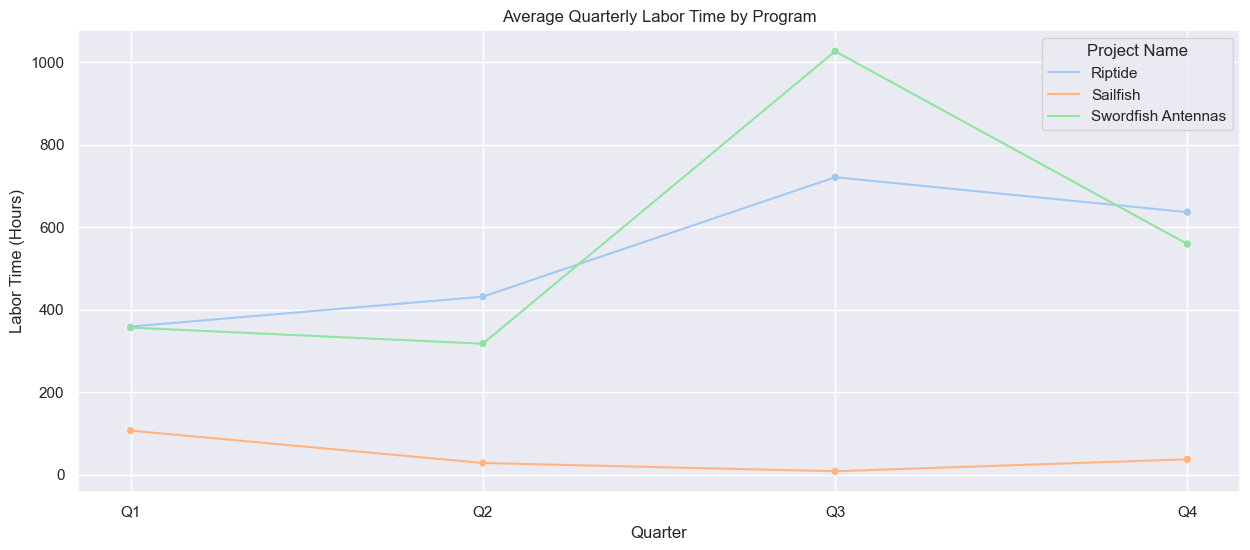

In [17]:
# Avg quarterly time by program
fig, ax = plt.subplots(figsize=(15, 6))

avg_quarterly_time_by_year_and_program = sie_fi_tasks_df.groupby(
    ["project_name", "year", "quarter"]
)["regular_time"].sum()

avg_quarterly_time_by_program = avg_quarterly_time_by_year_and_program.groupby(
    ["project_name", "quarter"]
).mean()

avg_quarterly_time_by_program = avg_quarterly_time_by_program.reset_index()

sns.lineplot(
    x="quarter",
    y="regular_time",
    data=avg_quarterly_time_by_program,
    hue="project_name",
)

sns.scatterplot(
    x="quarter",
    y="regular_time",
    data=avg_quarterly_time_by_program,
    hue="project_name",
    legend=False,
)

plt.xticks(
    ticks=range(1, 5),
    labels=["Q1", "Q2", "Q3", "Q4"],
)
plt.legend(title="Project Name")
plt.xlabel("Quarter")
plt.ylabel("Labor Time (Hours)")
plt.title("Average Quarterly Labor Time by Program")

In [18]:
# Project

In [19]:
# # Total time by task, broken down by project name
# fig, ax = plt.subplots(figsize=(10, 6))


# total_time_by_task = (
#     df_projects[df_projects["task_number"].isin(IMPORTANT_TASKS)]
#     .groupby(["project_name", "task_name"])["regular_time"]
#     .sum()
# )

# total_time_by_task = total_time_by_task.reset_index()

# total_time_by_task["task_name"] = [
#     "Installation",
#     "Stage & Factory/FAT",
#     "System Cabling/Inte/Racks",
#     "Systems Engineering",
#     "Installation",
#     "Stage & Factory/FAT",
#     "System Cabling/Inte/Racks",
#     "Systems Engineering",
# ]

# sns.barplot(
#     y="regular_time",
#     x="task_name",
#     data=total_time_by_task,
#     hue="project_name",
# )

# plt.legend(title="Project Name")
# plt.xlabel("Task Name")
# plt.ylabel("Labor Time (Hours)")
# plt.title("Total Time by Task")


# total_time_by_task

In [20]:
# dataframe where index is incurred_orgs, and columns are task_numbers, and values are the count of how many expenditure items are in each incurred_org and task_number, using pd.pivot_table


def time_by_task_and_org(df):
    return pd.pivot_table(
        df,
        index="incurred_org",
        columns="task_number",
        values="regular_time",
        aggfunc="sum",
    ).fillna(0)

In [21]:
time_by_task_and_org(df)

task_number                                       0  0.206       1  \
incurred_org                                                         
AS Antenna Products                          654.00    0.0   293.0   
AS R & D                                       0.00    0.0   621.0   
CS - Residential Field Ops - Installation    942.50    0.0     0.0   
Eng - AS                                   34660.68   43.0  2294.5   
Eng - AS Ground Sys and Admin                  0.00    0.0    72.0   
Eng - AS Maint & Support                     571.00    0.0   388.0   
Eng - GSN System Int & Test Government      2293.60    0.0     1.5   
Ops - AS Manufacturing                     57360.77    0.0    81.5   
Sat Prod Ops Atl - Logistics                2504.50    0.0   124.0   
VSAT Ntwks - Hardware Engineering              0.00    0.0     0.0   
VSAT Ntwks - Training                        399.50    0.0  1063.5   

task_number                                1.01.01.01.01.01.01  \
incurred_org                                                     
AS Antenna Products                                       0.00   
AS R & D                                                  0.00   
CS - Residential Field Ops - Installation                 0.00   
Eng - AS                                                 27.25   
Eng - AS Ground Sys and Admin                             0.00   
Eng - AS Maint & Support                                  0.00   
Eng - GSN System Int & Test Government                    0.00   
Ops - AS Manufacturing                                    0.00   
Sat Prod Ops Atl - Logistics                              0.00   
VSAT Ntwks - Hardware Engineering                         0.00   
VSAT Ntwks - Training                                     0.00   

task_number                                1.01.01.01.01.01.07  \
incurred_org                                                     
AS Antenna Products                                       0.00   
AS R & D                                                  0.00   
CS - Residential Field Ops - Installation                 0.00   
Eng - AS                                                  2.25   
Eng - AS Ground Sys and Admin                             0.00   
Eng - AS Maint & Support                                  0.00   
Eng - GSN System Int & Test Government                    0.00   
Ops - AS Manufacturing                                    0.00   
Sat Prod Ops Atl - Logistics                              0.00   
VSAT Ntwks - Hardware Engineering                         0.00   
VSAT Ntwks - Training                                     0.00   

task_number                                1.01.01.01.02.01.01  \
incurred_org                                                     
AS Antenna Products                                        0.0   
AS R & D                                                   0.0   
CS - Residential Field Ops - Installation                  0.0   
Eng - AS                                                   4.0   
Eng - AS Ground Sys and Admin                              0.0   
Eng - AS Maint & Support                                   0.0   
Eng - GSN System Int & Test Government                     0.0   
Ops - AS Manufacturing                                     0.0   
Sat Prod Ops Atl - Logistics                               0.0   
VSAT Ntwks - Hardware Engineering                          0.0   
VSAT Ntwks - Training                                      0.0   

task_number                                1.01.01.04.01.01.01  \
incurred_org                                                     
AS Antenna Products                                        0.0   
AS R & D                                                   0.0   
CS - Residential Field Ops - Installation                  0.0   
Eng - AS                                                   2.5   
Eng - AS Ground Sys and Admin                              0.0   
Eng - AS Maint & Support                          

In [22]:
df[df["task_number"].str.contains("")]

,project_name,project_number,task_name,task_number,incurred_org,regular_time,raw_cost,month,day_of_week,day_of_month,year,quarter
expenditure_item_date,,,,,,,,,,,,
2001-11-26,SKYSERVER (Arclight),R160737,DOCUMENTATION,52,VSAT Ntwks - Hardware Engineering,4.0,133.04,11,0,26,2001,4
2001-11-26,Bharat Electronics SO# 133076,165201,APPLICATION / SYSTEM,804,VSAT Ntwks - Training,8.0,148.32,11,0,26,2001,4
2001-11-26,TSI KA BAND SYSTEM,841042,SYS INTEG/FAT/TEARDO,3620,Eng - AS,6.0,166.02,11,0,26,2001,4
2001-11-26,SGS Engineering,I040209,Task 1,1,Eng - AS,2.0,55.34,11,0,26,2001,4
2001-11-26,SKYLINX CHASSIS MODIFICATION,R160638,ELECTRICAL DESIGN,14,VSAT Ntwks - Hardware Engineering,4.0,133.04,11,0,26,2001,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-15,Swordfish Antennas,1929,Inatllaiton Ant #3,4230,Eng - GSN System Int & Test Government,10.0,427.20,7,0,15,2024,3
2024-07-16,Swordfish Antennas,1929,Inatllaiton Ant #3,4230,Eng - GSN System Int & Test Government,12.0,512.64,7,1,16,2024,3
2024-07-17,Swordfish Antennas,1929,Inatllaiton Ant #3,4230,Eng - GSN System Int & Test Government,10.0,427.20,7,2,17,2024,3


In [23]:
with pd.option_context("display.max_rows", None):
    # Display the value counts of the task numbers
    print(df["task_number"].value_counts())

task_number
0                       9976
4200                    9378
3220                    5410
3180                    5341
3110                    4725
2100                    2954
1120                    2406
1000                    2312
9300                    1375
3210                    1004
1                        970
SPT.1110                 758
9300.1                   706
2                        648
3620                     592
5200                     587
5100                     578
3610                     574
3000                     564
4200.1                   550
1.03.01.01.03            513
1.05.01.01.01            492
2.6                      470
3300                     449
3250                     448
3100.1.13                427
1.01.01.06.01.01.02      409
1121                     399
3220.1                   398
4220                     383
1.07.06.01.01            369
904                      367
3181                     360
3220.2                   324
41

In [24]:
# Display the average date of each task number
print(
    df.reset_index()
    .groupby("task_number")["expenditure_item_date"]
    .mean()
    .sort_values()
)

task_number
1002        2001-11-29 00:00:00
52          2001-11-30 09:00:00
550         2001-12-05 00:00:00
166         2001-12-31 00:00:00
168         2002-01-03 06:00:00
                    ...        
4.1.11      2024-06-19 00:00:00
3160.1.01   2024-06-24 06:00:00
3190.9.61   2024-06-30 12:00:00
6089        2024-07-02 12:00:00
3502        2024-07-05 03:00:00
Name: expenditure_item_date, Length: 1034, dtype: datetime64[ns]


In [25]:
pd.set_option("display.max_rows", None)
df[df["task_number"].str.split(".").str.len() > 2]["project_name"].value_counts()

project_name
Thunderbolt                      6788
Spitfire 13M Qty 11              1391
O3b Teleport & Tier 1-Global      519
Thor                              499
BOEING-MUSTANG                    490
NGA-5B2-17-001 - ACQUISITION      346
LANCE                             327
KACST SB2 GW POC MASTER           298
M171596                           130
VS3 Deployment PM                 122
RTE COGS                          113
Spiderman M&SS                     67
Leapfrog Ground Segment            57
GOI M&SS                           57
Maxar M&SS                         54
Shiloh M&SS                        50
Barracuda                          45
BIAC M&SS                          40
Mustang M&SS                       35
GOI Phoenix M&SS                   32
USN Mid-Lats SSC                   32
GroundHog M&SS                     28
Larsen & Toubro GSAT-11 T&SS       21
BAE JP2008 P3                      21
Arabasat T&SS                      20
Amazon T&SS                        18

In [26]:
# dont display max rows
pd.set_option("display.max_rows", 10)
prod_3440 = df[
    df["project_number"].isin(
        [
            "1881",
            "1839",
            "1940",
            "1952",
            "1971",
            "1967",
            "1965",
            "1976",
            "5002",
        ]
    )
]

thor = df[df["project_name"] == "Thor"]

In [27]:
# Filter for only rows that have task numbers starting with "3110", "3180", "3220", "4200"
imp_tasks_3440 = prod_3440[prod_3440["task_number"].str[0:4].isin(IMPORTANT_TASKS)]

Censipam total labor time: 798.0 hours
SHILOH total labor time: 4628.0 hours
LANCE total labor time: 1562.75 hours
Wombat total labor time: 342.0 hours
Cobra total labor time: 3571.25 hours
DAF08 11M Replacement total labor time: 763.0 hours
BIAK 11 M System total labor time: 1045.0 hours
Bonaire total labor time: 4026.9 hours
NAVSOC-Peraton total labor time: 1297.75 hours


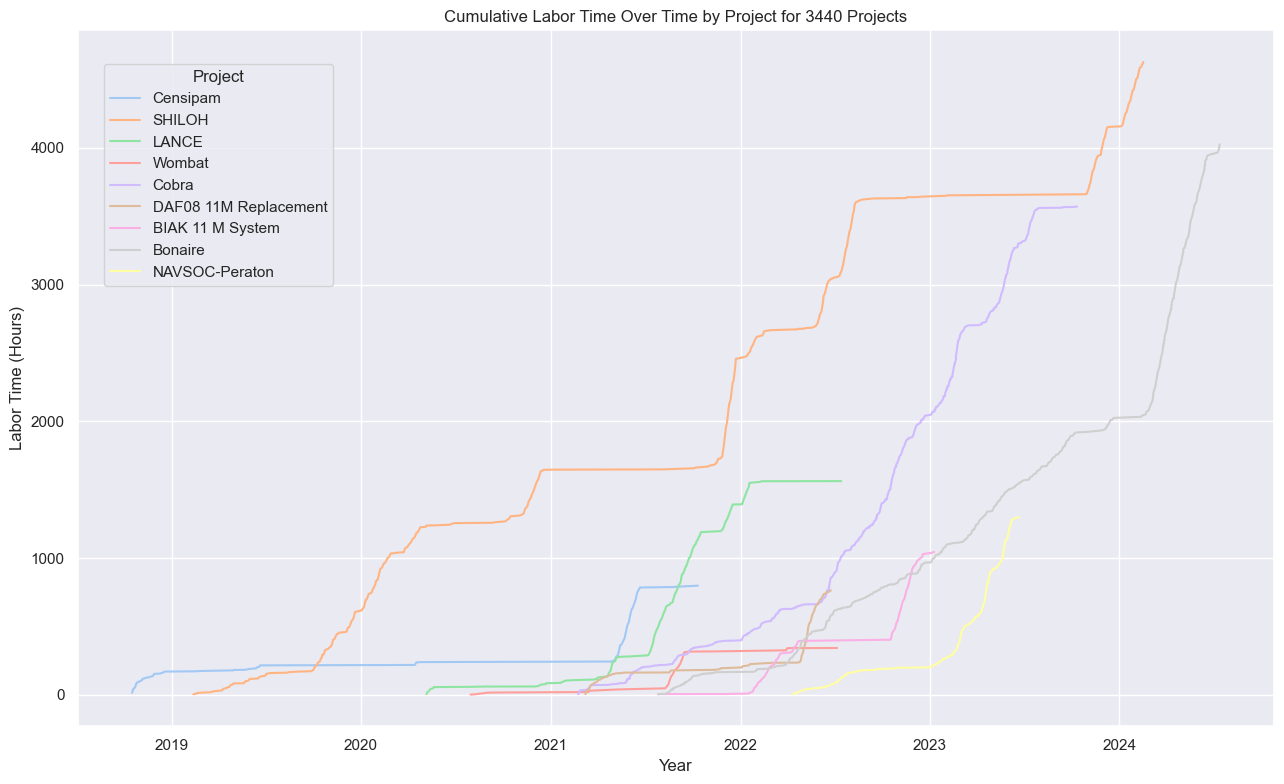

In [28]:
# Plot cumulative labor time over time for each 3440 project for task numbers that start with "3110", "3180", "3220", "4200" on one plot
fig, ax = plt.subplots(figsize=(13, 8))

for project in imp_tasks_3440["project_name"].unique():
    project_df = imp_tasks_3440[imp_tasks_3440["project_name"] == project]
    cumul_labor_time = np.cumsum(project_df["regular_time"])

    ax.plot(cumul_labor_time.index, cumul_labor_time.values, label=project)

    last_time = project_df["regular_time"].sum()
    print(f"{project} total labor time: {last_time} hours")

ax.set_xlabel("Year")
ax.set_ylabel("Labor Time (Hours)")
ax.set_title("Cumulative Labor Time Over Time by Project for 3440 Projects")

fig.legend(title="Project", loc="upper left", bbox_to_anchor=(0.08, 0.92))
fig.tight_layout()

Censipam total labor cost: $29846.50
SHILOH total labor cost: $160461.31
LANCE total labor cost: $51141.82
Wombat total labor cost: $10539.27
Cobra total labor cost: $134536.66
DAF08 11M Replacement total labor cost: $30437.75
BIAK 11 M System total labor cost: $37909.69
Bonaire total labor cost: $154422.70
NAVSOC-Peraton total labor cost: $50830.89


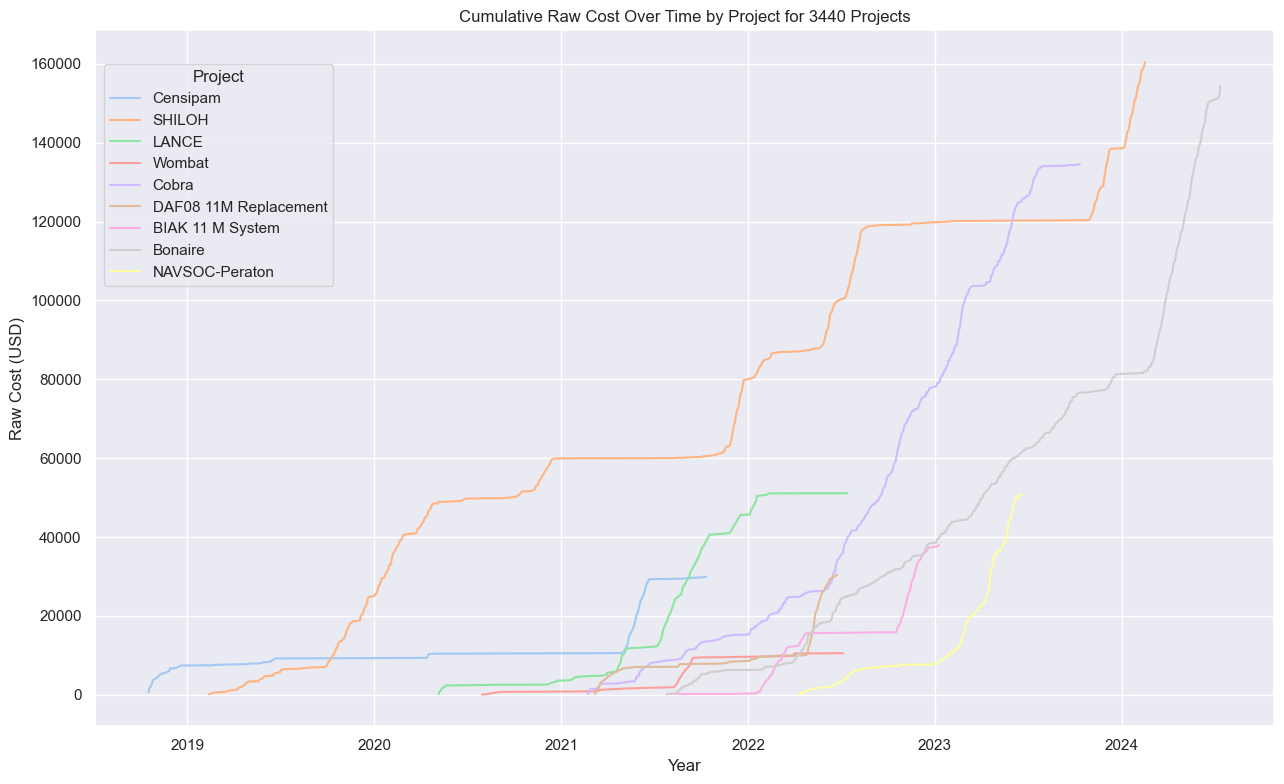

In [29]:
fig, ax = plt.subplots(figsize=(13, 8))

for project in imp_tasks_3440["project_name"].unique():
    project_df = imp_tasks_3440[imp_tasks_3440["project_name"] == project]
    cumul_labor_cost = np.cumsum(project_df["raw_cost"])

    ax.plot(cumul_labor_cost.index, cumul_labor_cost.values, label=project)

    last_time = project_df["raw_cost"].sum()
    print(f"{project} total labor cost: ${last_time:.2f}")

ax.set_xlabel("Year")
ax.set_ylabel("Raw Cost (USD)")
ax.set_title("Cumulative Raw Cost Over Time by Project for 3440 Projects")

fig.legend(title="Project", loc="upper left", bbox_to_anchor=(0.08, 0.92))
fig.tight_layout()

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore

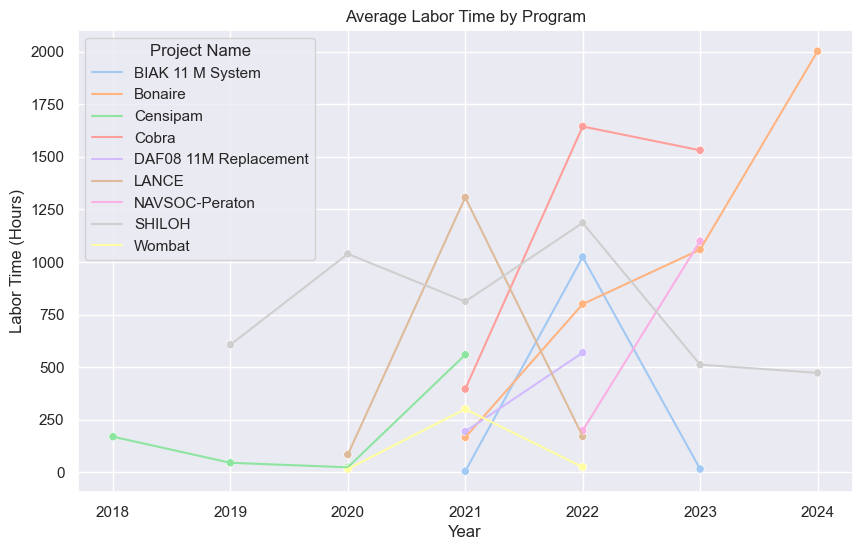

In [30]:
plot_yearly_stat_by_program(imp_tasks_3440, "regular_time")

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore

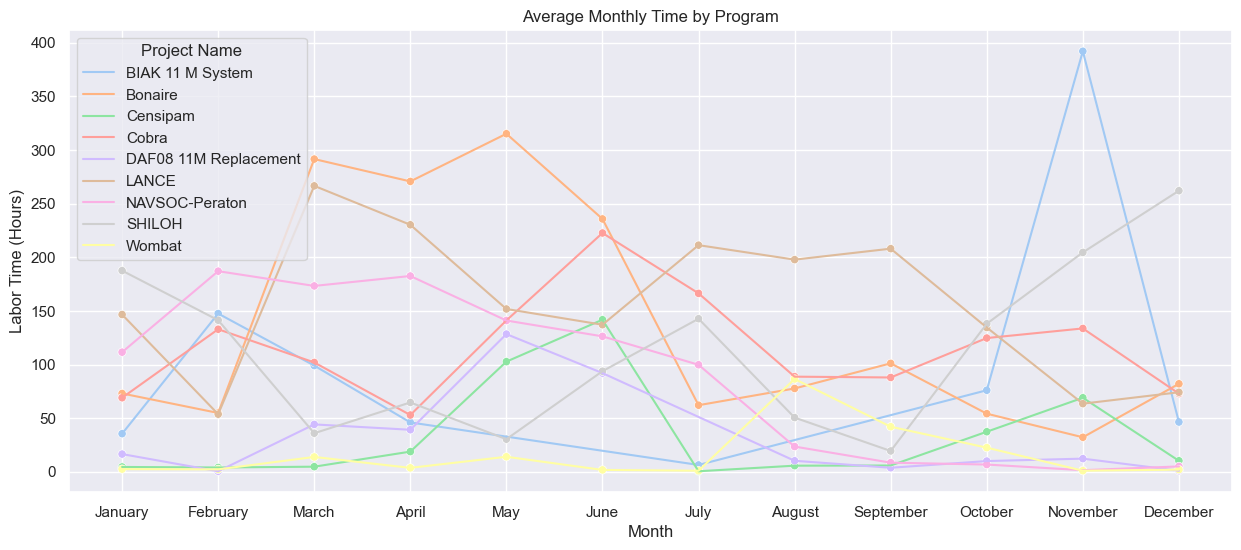

In [31]:
plot_monthly_stat_by_program(prod_3440, stat="regular_time")

In [32]:
# Plot total time by task numbers that start with "3110", "3180", "3220", "4200", with each plot being a different subplot and project from prod_3440
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, project in enumerate(imp_tasks_3440["project_name"].unique()):
    project_df = imp_tasks_3440[imp_tasks_3440["project_name"] == project]
    axs[i // 3, i % 3] = plot_total_time_by_task_number(
        project_df, ax=axs[i // 3, i % 3]
    )
    axs[i // 3, i % 3].set_title("Labor Time by Task Number for " + project)

fig.tight_layout()

*Notes on above figure*
- 3110 is really low for some of these - why?
- Cobra has a lot of decimal breakdowns - are there multiple subsystems?
- Scales are different between all of these - does this make sense given real world? Maybe some projects are still going on.
- (SHILOH, LANCE, potentially Cobra), (Censipam, Wombat, Bonaire, maybe DAF08 11m Replacement) potential similar groupings.

Text(0.5, 1.0, 'Aggregated Labor Time by Task for Cobra')

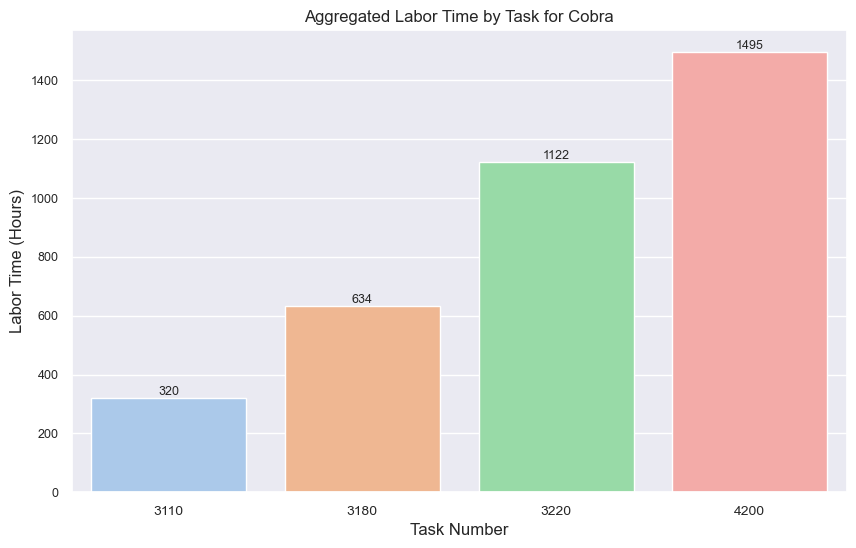

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

cobra_imp_tasks_df = prod_3440[prod_3440["project_name"] == "Cobra"]
cobra_imp_tasks_df.loc[:, "task_number"] = (
    cobra_imp_tasks_df["task_number"].str.split(".").str[0]
)

cobra_imp_tasks_df = cobra_imp_tasks_df[
    cobra_imp_tasks_df["task_number"].isin(IMPORTANT_TASKS)
]

plot_total_time_by_task_number(cobra_imp_tasks_df, ax=ax)

ax.set_title("Aggregated Labor Time by Task for Cobra")

Text(0.5, 1.0, 'Aggregated Labor Time by Task for Censipam')

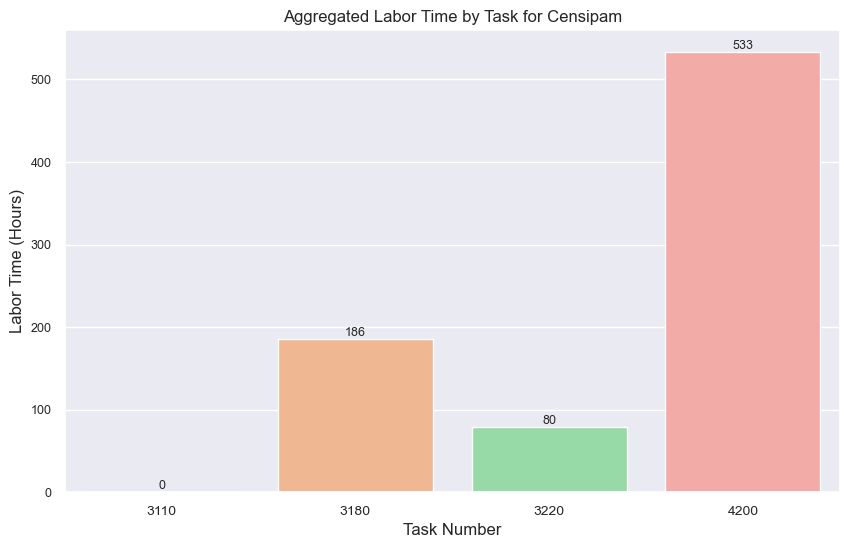

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

cen_imp_tasks_df = prod_3440[prod_3440["project_name"] == "Censipam"]
cen_imp_tasks_df.loc[:, "task_number"] = (
    cen_imp_tasks_df["task_number"].str.split(".").str[0]
)

# insert row
cen_imp_tasks_df = pd.concat(
    [
        pd.DataFrame(
            {
                "expenditure_item_date": pd.Timestamp("2021-12-31"),
                "task_number": "3110",
                "task_name": "System Cabling/Inte/Racks",
                "regular_time": 0,
                "raw_cost": 0,
                "project_name": "Censipam",
                "project_number": "1976",
                "incurred_org": "CEN",
                "month": 12,
                "day_of_week": 4,
                "day_of_month": 31,
                "year": 2021,
                "quarter": 4,
            },
            index=[0],
        ),
        cen_imp_tasks_df,
    ]
)

cen_imp_tasks_df = cen_imp_tasks_df[
    cen_imp_tasks_df["task_number"].isin(IMPORTANT_TASKS)
]

plot_total_time_by_task_number(cen_imp_tasks_df, ax=ax)

ax.set_title("Aggregated Labor Time by Task for Censipam")

<Axes: title={'center': 'Total Time by Task Number'}, xlabel='Task Number', ylabel='Labor Time (Hours)'>

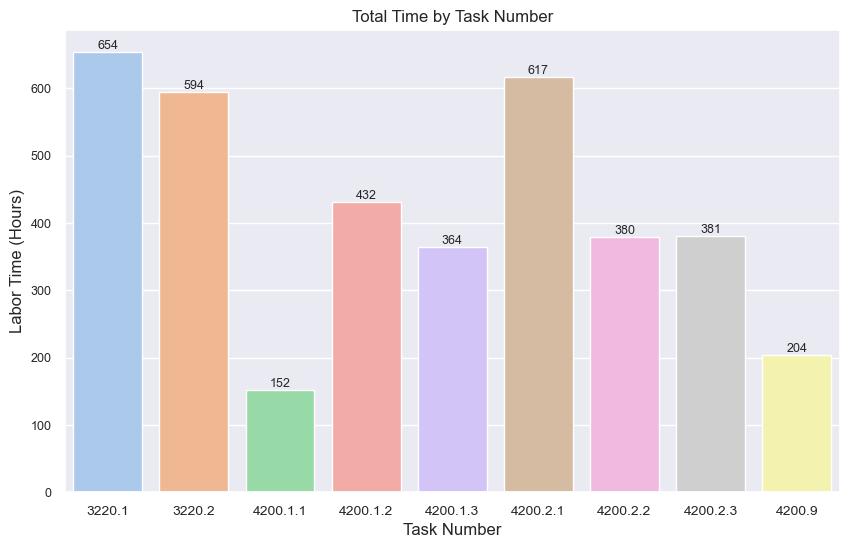

In [ ]:
# total time by task number for prod_th3000
fig, ax = plt.subplots(figsize=(10, 6))
thor_imp_tasks = thor[thor["task_number"].str[0:4].isin(IMPORTANT_TASKS)]

plot_total_time_by_task_number(thor_imp_tasks, ax=ax)

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

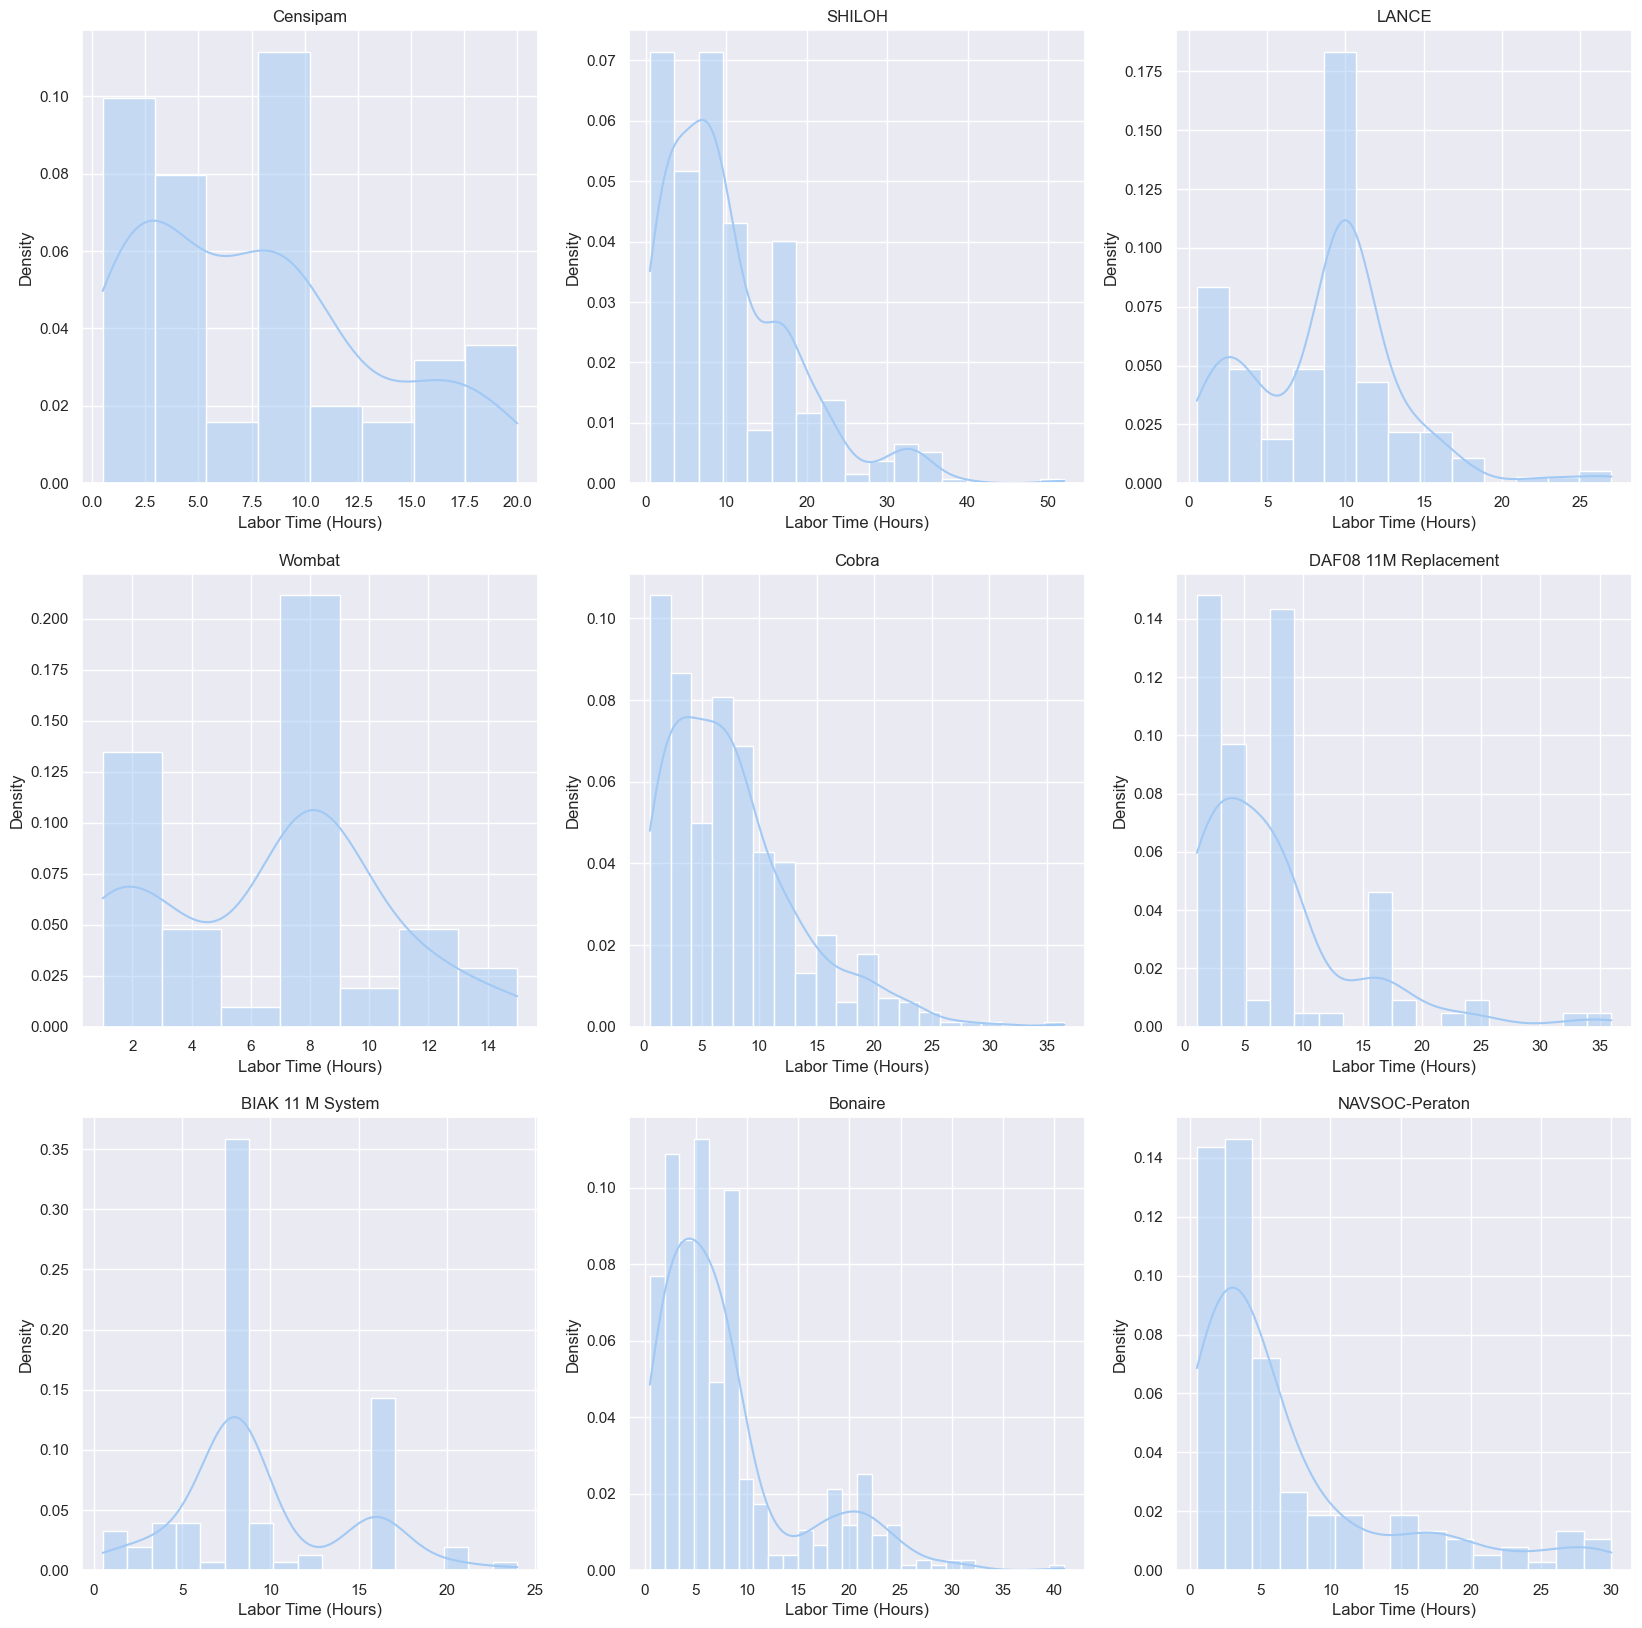

In [ ]:
# Density histogram of regular time for each project in prod_3440 in 9 subplots

daily_3440 = imp_tasks_3440.groupby(["expenditure_item_date", "project_name"])[
    ["regular_time", "raw_cost"]
].sum()

fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, project in enumerate(imp_tasks_3440["project_name"].unique()):
    project_df = daily_3440.loc[(slice(None), project), :]
    sns.histplot(
        data=project_df,
        x="regular_time",
        kde=True,
        stat="density",
        ax=axs[i // 3, i % 3],
    )
    axs[i // 3, i % 3].set_title(project)

    axs[i // 3, i % 3].set_xlabel("Labor Time (Hours)")
    axs[i // 3, i % 3].set_ylabel("Density")

c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aiyer\AppData\Local\anaconda3\envs\env1\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aiyer\AppData\Local\anacond

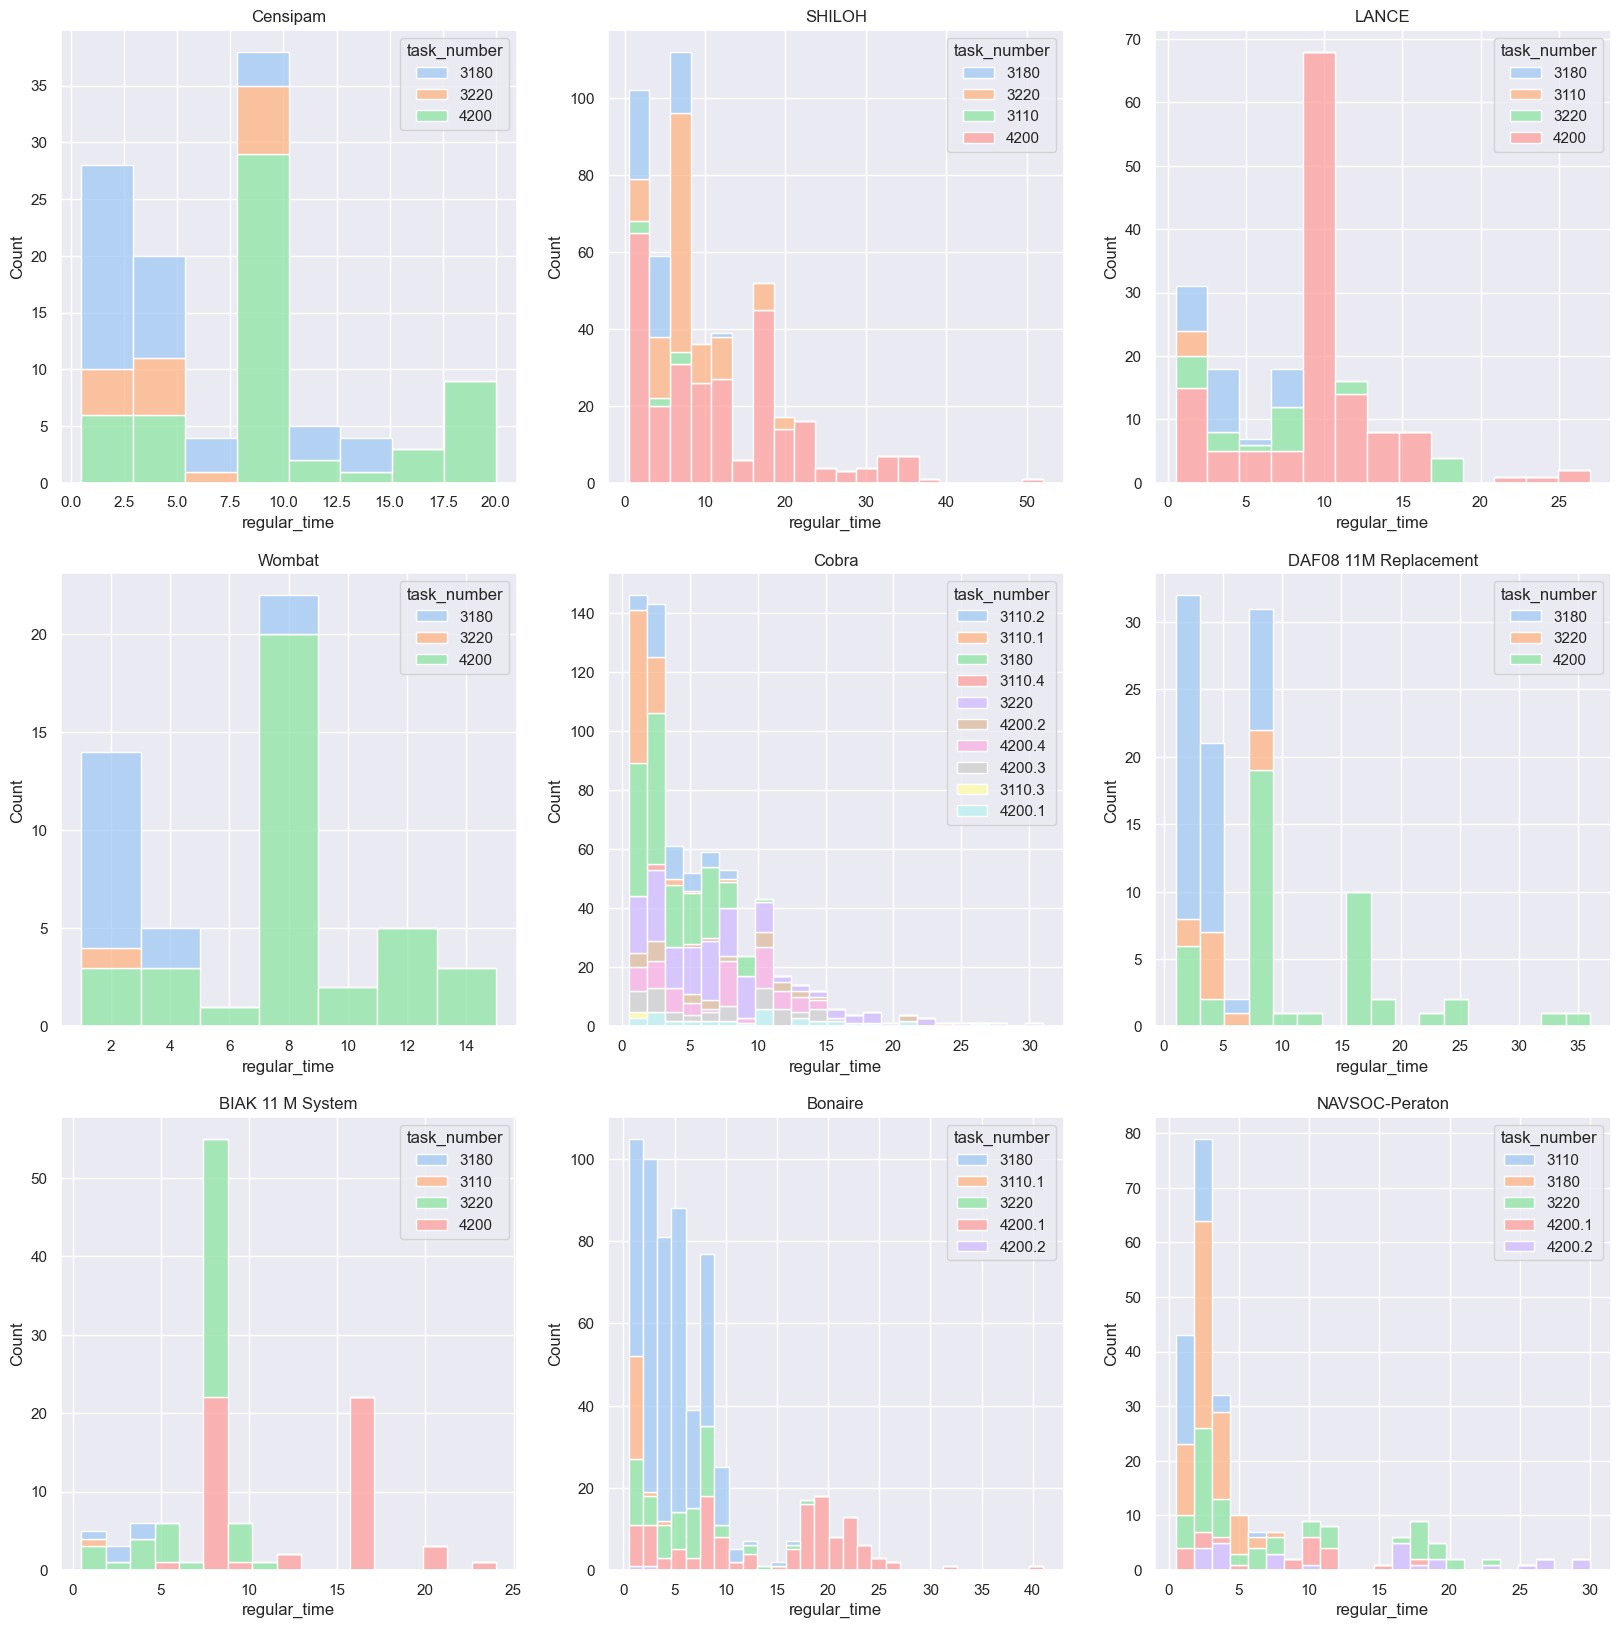

In [ ]:
imp_tasks_3440_daily = imp_tasks_3440.groupby(
    ["expenditure_item_date", "project_name", "task_number"]
)[["regular_time", "raw_cost"]].sum()
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, project in enumerate(imp_tasks_3440["project_name"].unique()):
    project_df = imp_tasks_3440_daily.loc[(slice(None), project), :]
    sns.histplot(
        data=project_df,
        x="regular_time",
        ax=axs[i // 3, i % 3],
        hue="task_number",
        multiple="stack",
    )
    axs[i // 3, i % 3].set_title(project)

KeyError: '4200.4'

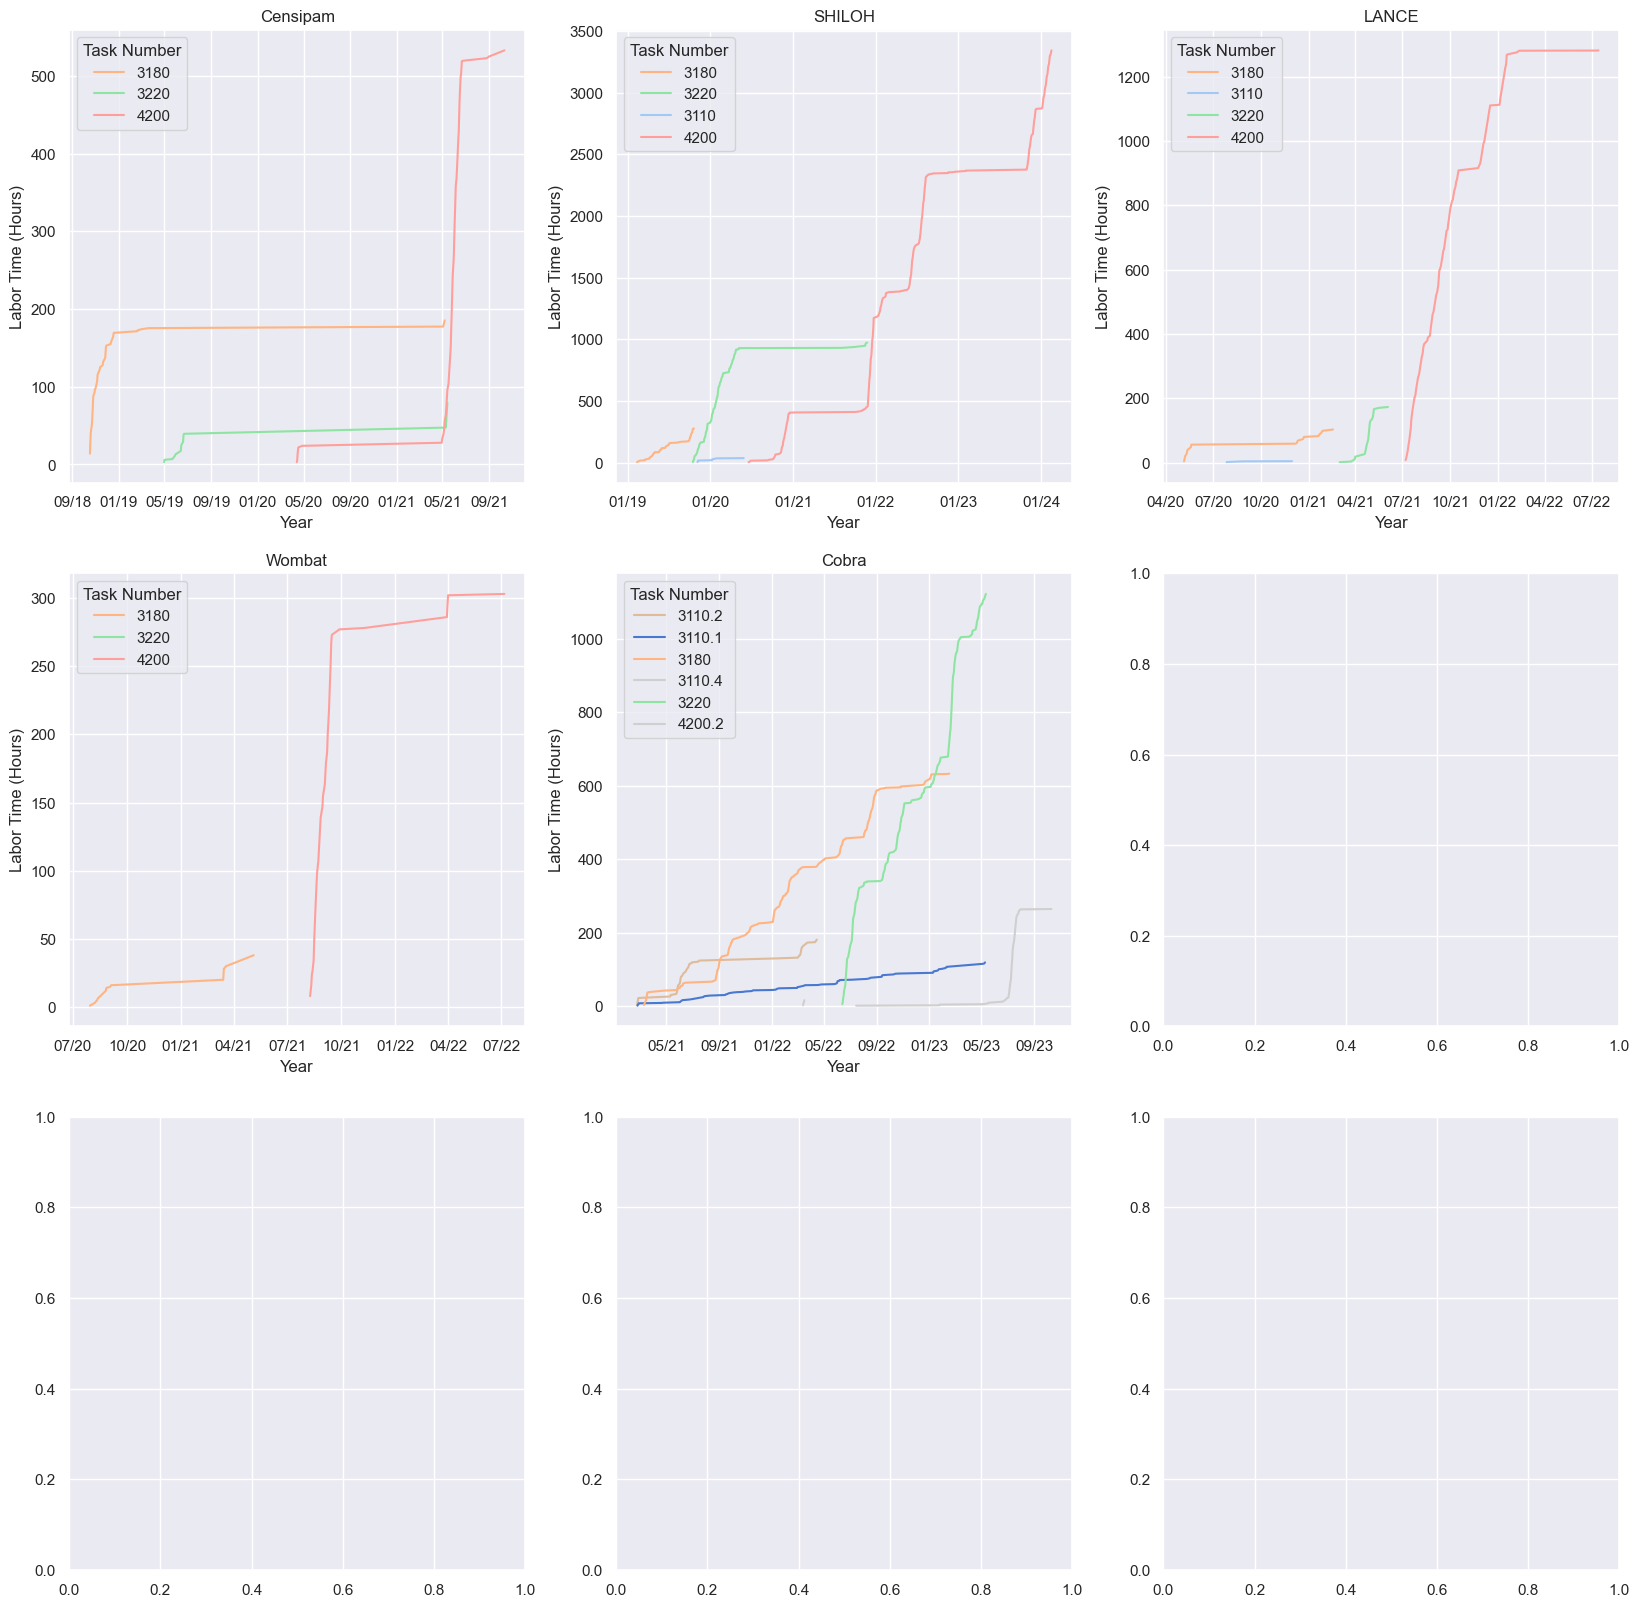

In [ ]:
# 9 subplots of cumulative labor time over time for each project in prod_3440, hued by task number
import matplotlib.dates as mdates

fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, project in enumerate(imp_tasks_3440["project_name"].unique()):
    project_df = imp_tasks_3440[imp_tasks_3440["project_name"] == project]
    for task_number in project_df["task_number"].unique():
        task_df = project_df[project_df["task_number"] == task_number]
        cumul_labor_time = np.cumsum(task_df["regular_time"])
        axs[i // 3, i % 3].plot(
            cumul_labor_time.index,
            cumul_labor_time.values,
            label=task_number,
            color=task_colors[task_number],
        )

        axs[i // 3, i % 3].set_xlabel("Year")
        axs[i // 3, i % 3].set_ylabel("Labor Time (Hours)")
        axs[i // 3, i % 3].set_title(project)
        axs[i // 3, i % 3].legend(title="Task Number")
        axs[i // 3, i % 3].xaxis.set_major_formatter(mdates.DateFormatter(r"%m/%y"))

plt.show()

In [ ]:
df[df["task_number"].str[0:4].isin(IMPORTANT_TASKS)]["incurred_org"].value_counts()

incurred_org
Eng - AS                                  27247
Eng - AS Maint & Support                    903
Eng - GSN System Int & Test Government      394
Ops - AS Manufacturing                       34
Name: count, dtype: int64

In [ ]:
df_modern = df[df.index.year >= 2020]
df_modern[df_modern["task_number"].str[0:4].isin(IMPORTANT_TASKS)][
    "incurred_org"
].value_counts()

incurred_org
Eng - AS                                  11119
Eng - GSN System Int & Test Government      394
Ops - AS Manufacturing                       13
Name: count, dtype: int64

In [ ]:
prod_3440.value_counts(["project_name", "project_number"])

project_name           project_number
LANCE                  1940              1204
Cobra                  1965               792
Bonaire                1976               775
SHILOH                 1881               697
NAVSOC-Peraton         5002               314
Censipam               1839               196
DAF08 11M Replacement  1971               144
BIAK 11 M System       1967               118
Wombat                 1952                99
Name: count, dtype: int64

In [ ]:
df[df["project_name"] == "Thunderbolt"]

,project_name,project_number,task_name,task_number,incurred_org,regular_time,raw_cost,month,day_of_week,day_of_month,year,quarter
expenditure_item_date,,,,,,,,,,,,
2019-05-15,Thunderbolt,1899,Chief Engineer,1.03.01.01.01,Eng - AS,1.20,71.26,5,2,15,2019,2
2019-05-29,Thunderbolt,1899,13m PE,1.03.01.01.02,Eng - AS,1.50,89.06,5,2,29,2019,2
2019-05-30,Thunderbolt,1899,13m MVP Design,1.01.02.07.01.01.01,Eng - AS,5.50,326.54,5,3,30,2019,2
2019-05-31,Thunderbolt,1899,13m MVP Design,1.01.02.07.01.01.01,Eng - AS,8.00,474.96,5,4,31,2019,2
2019-06-03,Thunderbolt,1899,13m PE,1.03.01.01.02,Eng - AS,1.00,59.37,6,0,3,2019,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-11,Thunderbolt,1899,24m Ant Ops Stack,1.05.01.01.01,Eng - GSN System Int & Test Government,7.25,550.13,7,3,11,2024,3
2024-07-11,Thunderbolt,1899,13m IOC Install&SAT,1.10.01.01.02,Eng - GSN System Int & Test Government,10.00,358.60,7,3,11,2024,3
2024-07-12,Thunderbolt,1899,24m Ant Ops Stack,1.05.01.01.01,Eng - GSN System Int & Test Government,8.00,607.04,7,4,12,2024,3


In [ ]:
# Closed programs:
# 1881 - SHILOH
# 1839 - Censipam
# 1940 - LANCE
# 1952 - Wombat
# 1971 - DAF08 11M Replacement
# 1967 - BIAK 11 M System
# 1965 - Cobra
# 5002 - NAVSOC-Peraton

# Open programs:
# 1976 - Bonaire
# 1899 - Thunderbolt

In [ ]:
prod_3440[prod_3440["regular_time"] == 0]

,project_name,project_number,task_name,task_number,incurred_org,regular_time,raw_cost,month,day_of_week,day_of_month,year,quarter
expenditure_item_date,,,,,,,,,,,,


<Axes: xlabel='regular_time', ylabel='raw_cost'>

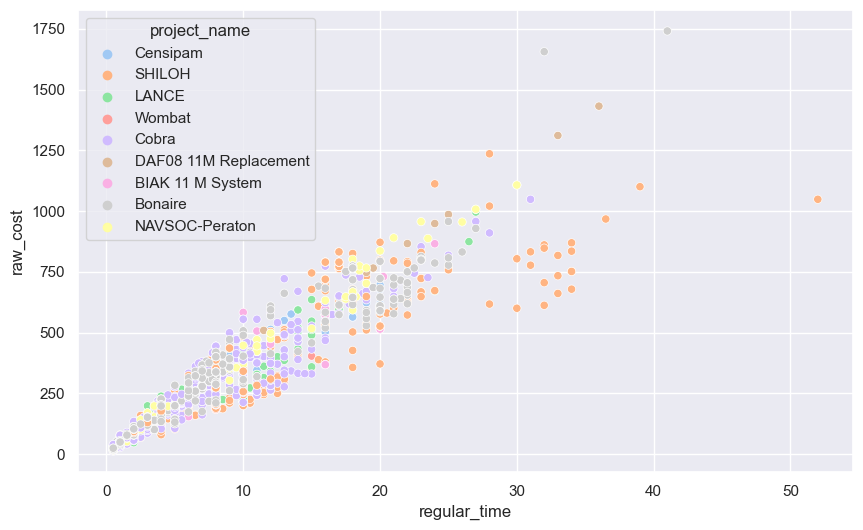

In [ ]:
# Scatter plot of regular time vs raw cost for prod_3440

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=imp_tasks_3440, x="regular_time", y="raw_cost", hue="project_name")

Text(0.5, 1.0, 'Labor Time vs Raw Cost for 3440 Projects (Excluding Cobra)')

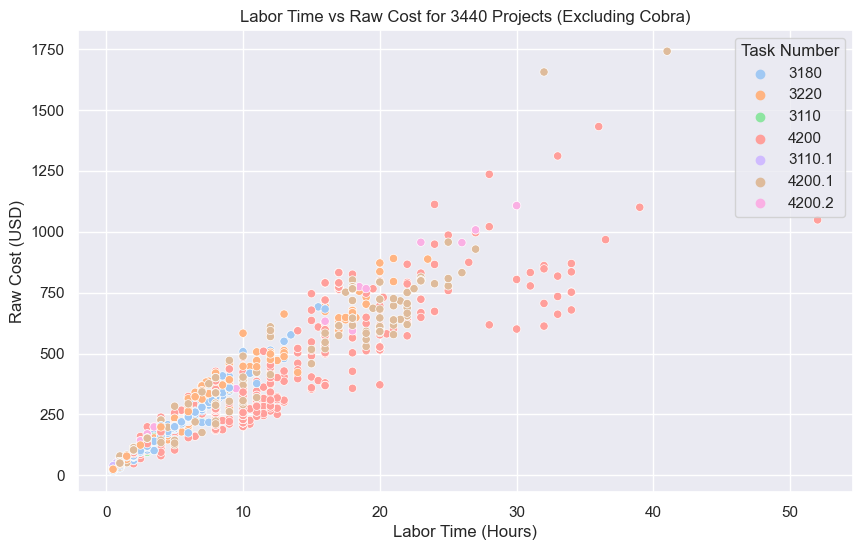

In [ ]:
# Scatterplot of regular time vs raw cost for prod_3440, hued by task number
fig, ax = plt.subplots(figsize=(10, 6))
# imp_tasks_3440_simple = imp_tasks_3440
# imp_tasks_3440_simple["task_number"] = (
#     imp_tasks_3440_simple["task_number"].str.split(".").str[0]
# )
sns.scatterplot(
    data=imp_tasks_3440[imp_tasks_3440["project_name"] != "Cobra"],
    x="regular_time",
    y="raw_cost",
    hue="task_number",
)

plt.legend(title="Task Number")
plt.xlabel("Labor Time (Hours)")
plt.ylabel("Raw Cost (USD)")
plt.title("Labor Time vs Raw Cost for 3440 Projects (Excluding Cobra)")

Text(0.5, 1.0, 'Average Cost per Hour by Project for 3440 Projects')

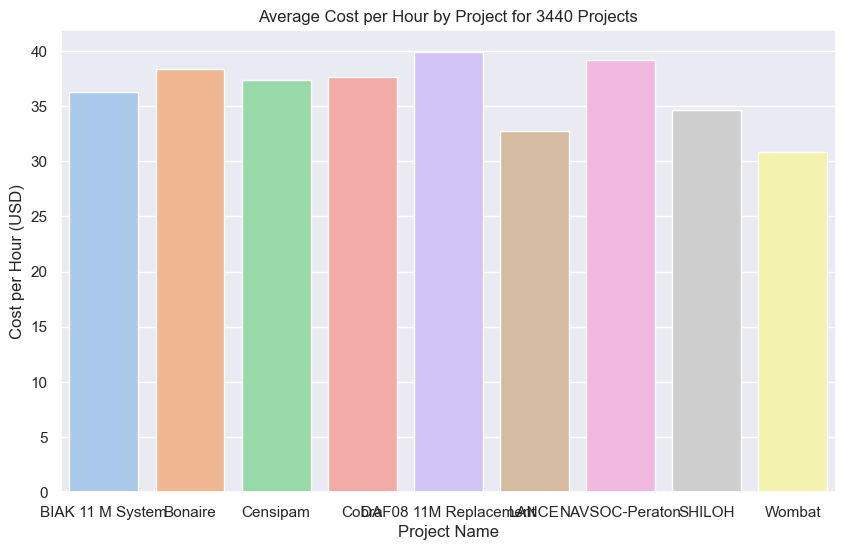

In [ ]:
# Barplot comparing average raw_cost / regular time by project for prod_3440
fig, ax = plt.subplots(figsize=(10, 6))

avg_raw_cost_by_project = imp_tasks_3440.groupby("project_name")["raw_cost"].mean()
avg_regular_time_by_project = imp_tasks_3440.groupby("project_name")[
    "regular_time"
].mean()

avg_cost_per_hour_by_project = avg_raw_cost_by_project / avg_regular_time_by_project

sns.barplot(x=avg_cost_per_hour_by_project.index, y=avg_cost_per_hour_by_project)

plt.xlabel("Project Name")
plt.ylabel("Cost per Hour (USD)")
plt.title("Average Cost per Hour by Project for 3440 Projects")

Text(0.5, 1.0, 'Average Cost per Hour by Task for 3440 Projects')

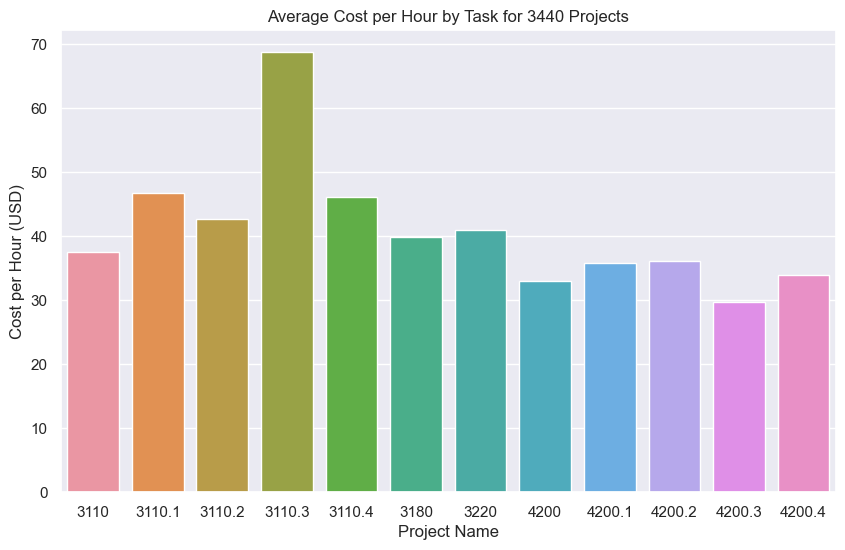

In [ ]:
# Barplot comparing average raw_cost / regular time by project for prod_3440
fig, ax = plt.subplots(figsize=(10, 6))

avg_raw_cost_by_project = imp_tasks_3440.groupby("task_number")["raw_cost"].mean()
avg_regular_time_by_project = imp_tasks_3440.groupby("task_number")[
    "regular_time"
].mean()

avg_cost_per_hour_by_project = avg_raw_cost_by_project / avg_regular_time_by_project

sns.barplot(x=avg_cost_per_hour_by_project.index, y=avg_cost_per_hour_by_project)

plt.xlabel("Project Name")
plt.ylabel("Cost per Hour (USD)")
plt.title("Average Cost per Hour by Task for 3440 Projects")

In [ ]:
imp_tasks_df[imp_tasks_df["task_number"].str.contains(".", regex=False)][
    [
        "project_number",
        "project_name",
    ]
].value_counts()

project_number  project_name               
1938            Thor                           745
1359            BAE JP2008 P3                  532
1552            Raytheon-APEX                  423
1965            Cobra                          328
1858            Spiderman                      255
                                              ... 
1935            Italy - Colombia 5.4m            2
5019            Coco                             2
2626591         XCI VS2 RF Systems               1
1520            TSA- MNLA 9M Ka-Band             1
C204331         7.3m & Civils: RTE S Africa      1
Name: count, Length: 39, dtype: int64

C:\Users\aiyer\AppData\Local\Temp\ipykernel_11792\4058572338.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bonaire["task_number"] = bonaire["task_number"].str.split(".").str[0]


Text(0.5, 1.0, 'Labor Time by Task for Bonaire')

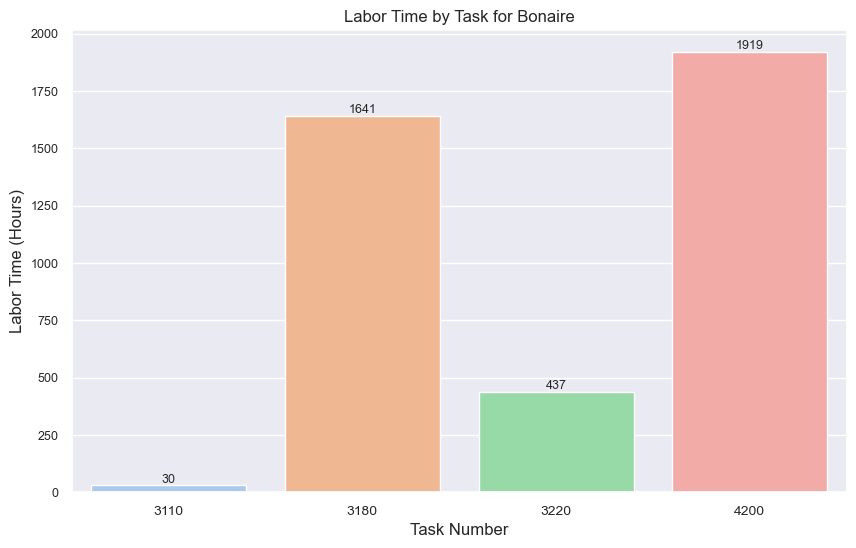

In [ ]:
# Barplot of bonaire labor time by task number, with 4200.1 and 4200.2 as the same 4200 bar. use plot_total_time_by_task_number

fig, ax = plt.subplots(figsize=(10, 6))

bonaire = imp_tasks_df[imp_tasks_df["project_name"] == "Bonaire"]
bonaire["task_number"] = bonaire["task_number"].str.split(".").str[0]

plot_total_time_by_task_number(bonaire, ax=ax)

ax.set_title("Labor Time by Task for Bonaire")

C:\Users\aiyer\AppData\Local\Temp\ipykernel_11792\3636463859.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censipam["task_number"] = censipam["task_number"].str.split(".").str[0]


Text(0.5, 1.0, 'Labor Time by Task for Censipam')

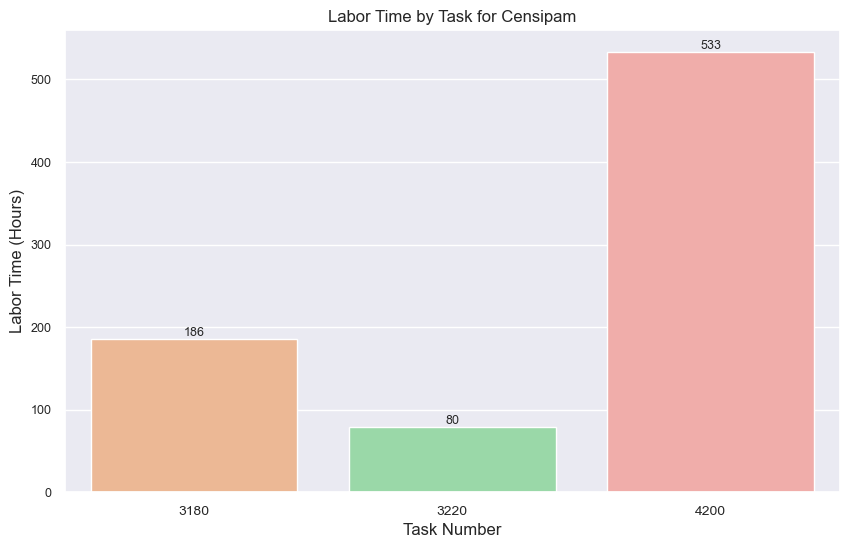

In [ ]:
# Barplot of censipam labor time by task number, with bar colors according to the palette, starting from the second color in the palette.

fig, ax = plt.subplots(figsize=(10, 6))

censipam = imp_tasks_df[imp_tasks_df["project_name"] == "Censipam"]
censipam["task_number"] = censipam["task_number"].str.split(".").str[0]

plot_total_time_by_task_number(censipam, ax=ax)

# set colors of bars to the palette starting from the second color
bars = ax.patches
# Change bar colors
for i, bar in enumerate(bars):
    bar.set_color(sns.color_palette("pastel", desat=0.7)[i + 1])
    # bars have a white outline
    bar.set_edgecolor("white")
ax.set_title("Labor Time by Task for Censipam")